# Truncated and folded distributions

This tutorial will cover how to implement your own
truncated distribution in NumPyro.
It is assumed that you're already familiar with the basics of NumPyro.
To get the most out of this tutorial, you'll need some background in probability.

**Contents**
* [0. Setup](#0)
* [1. What is a truncated distribution?](#1)
* [2. What is a folded distribution?](#2)
* [3. Sampling from truncated and folded distributions](#3)
* [4. Ready-to-use truncated and folded distributions](#4)
* [5. Building your own truncanted distributions](#5)
    * [5.1 Recap of NumPyro distributions](#5.1)
    * [5.2 Right-truncated normal](#5.2)
    * [5.3 Left-truncated Poisson](#5.3)
* [6. References and related material](#6)

To run this notebook, we are going to need the following imports

**Setup**  <a class="anchor" id="0"></a>

In [40]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import lax, random
from jax.scipy.special import ndtr, ndtri
from jax.scipy.stats import poisson, norm
from numpyro.distributions import (
    constraints,
    Distribution,
    FoldedDistribution,
    SoftLaplace,
    StudentT,
    TruncatedDistribution,
    TruncatedNormal,
)
from numpyro.distributions.util import promote_shapes
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS, Predictive
from scipy.stats import poisson as sp_poisson

numpyro.enable_x64()
RNG = random.PRNGKey(0)
MCMC_KWARGS = dict(
    num_warmup=2000,
    num_samples=2000,
    num_chains=4,
    chain_method="sequential",
)

## 1. What is a truncated distribution? <a class="anchor" id="1"></a>

The **support** of a probability distribution is the set of values
in the domain with **non-zero probability**. For example, the
support of the normal distribution is the whole real line (even if
the density gets very small as we move away from the mean, technically
speaking, it is never quite zero). The support of the uniform distribution,
as coded in `jax.random.uniform` with the default arguments, is the interval $\left[0, 1)\right.$, because any
value outside of that interval has zero probability. The support of the Poisson distribution is the set of non-negative integers, etc.

**Truncating** a distribution makes its support smaller
so that any value outside our desired domain has zero probability. In practice, this can be useful
for modelling situations in which certain biases are introduced during data collection.
For example, some physical detectors only get triggered when the signal is above some
minimum threshold, or sometimes the detectors fail if the signal exceeds a certain value.
As a result, the **observed values are constrained to be within a limited range of values**,
even though the true signal does not have the same constraints.
See, for example, section 3.1 of _Information Theory and Learning Algorithms_ by David Mackay.
Naively, if $S$ is the support of the original density $p_Y(y)$, then by truncating to a new support
$T\subset S$ we are effectively defining a new random variable $Z$ for which the density is

$$
  p_Z(z) \propto
    \begin{cases}
      p_Y(z) & \text{if $z$ is in $T$}\\
      0 & \text{if $z$ is outside $T$}\\
    \end{cases}       
$$

The reason for writing a $\propto$ (proportional to) sign instead of a strict equation is that,
defined in the above way, the resulting function does not integrate to $1$ and so it cannot be strictly considered a probability density. To make it into a probability density **we need to re-distribute the truncated mass**
among the part of the distribution that remains. To do this, we simply re-weight every point by the same constant:

$$
  p_Z(z) =
    \begin{cases}
      \frac{1}{M}p_Y(z) & \text{if $z$ is in $T$}\\
      0 & \text{if $z$ is outside $T$}\\
    \end{cases}       
$$

where $M = \int_T p_Y(y)\mathrm{d}y$.

In practice, the truncation is often one-sided. This means that if, for example, the support before truncation is the interval $(a, b)$, then the support after truncation is of the form $(a, c)$ or $(c, b)$, with $a < c < b$. The figure below illustrates a left-sided truncation at zero of a normal distribution $N(1, 1)$.

<img src="https://i.ibb.co/6vHyFfq/truncated-normal.png" alt="truncated" width="900"/>

The original distribution (left side) is truncated at the vertical dotted line. The truncated mass (orange region) is redistributed in the new support (right side image) so that the total area under the curve remains equal to 1 even after truncation. This method of re-weighting ensures that the density ratio between any two points, $p(a)/p(b)$ remains the same before and after the reweighting is done (as long as the points are inside the new support, of course).

**Note**: Truncated data is different from _censored_ data. Censoring also hides values that are outside some desired support but, contrary to truncated data, we know when a value has been censored. The typical example is the household scale which does not report values above 300 pounds. Censored data will not be covered in this tutorial.

## 2. What is a folded distribution?  <a class="anchor" id="2"></a>

**Folding** is achieved by taking the absolute value of a random variable, $Z = \lvert Y \rvert$. This obviously modifies the support of the original distribution since negative values now have zero
probability:

$$
  p_Z(z) =
    \begin{cases}
      p_Y(z) + p_Y(-z) & \text{if $z\ge 0$}\\
      0 & \text{if $z\lt 0$}\\
    \end{cases}       
$$

The figure below illustrates a folded normal distribution $N(1, 1)$.

<img src="https://i.ibb.co/3d2xJbc/folded-normal.png" alt="folded" width="900"/>

As you can see, the resulting distribution is different from the truncated case. In particular, the density ratio between points, $p(a)/p(b)$, is in general not the same after folding. For some examples in which folding is relevant see references [3](#ref3) and [4](#ref4).

If the original distribution is symmetric around zero, then folding and truncating at zero have the same effect.

## 3. Sampling from truncated and folded distributions <a class="anchor" id="3"></a>

**Truncated distributions**

Usually, we already have a sampler for the pre-truncated distribution (e.g. `np.random.normal`).
So, a seemingly simple way of generating samples from the truncated distribution would be to
sample from the original distribution, and then discard the samples that are outside the 
desired support. For example, if we wanted samples from a normal distribution truncated to the
support $(-\infty, 1)$, we'd simply do:

```python
upper = 1
samples = np.random.normal(size=1000)
truncated_samples = samples[samples < upper]
```

This is called **_rejection sampling_ but it is not very efficient**.
If the region we truncated had a sufficiently high probability mass, then we'd be discarding a lot of samples and it might be a while before we accumulate sufficient samples for the truncated distribution. For example, the above snippet would only result in $\sim 840$ truncated samples even though we initially drew $1000$. This can easily get a lot worse for other combinations of parameters.
A **more efficient** approach is to use a method known as [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling).
In this method, we first sample from a uniform distribution in (0, 1) and then transform those samples with the inverse cumulative distribution of our truncated distribution.
This method ensures that no samples are wasted in the process, though it does have the slight complication that
**we need to calculate the inverse CDF (ICDF)** of our truncated distribution. This might sound too complicated at first but, with a bit of algebra, we can often calculate the truncated ICDF in terms of the untruncated ICDF. The untruncated ICDF for many distributions is already available.

**Folded distributions**

This case is a lot simpler. Since we already have a sampler for the pre-folded distribution, all we need to do is to take the absolute value of those samples:

```python
samples = np.random.normal(size=1000)
folded_samples = np.abs(samples)
```

## 4. Ready to use truncated and folded distributions <a class="anchor" id="4"></a>

The later sections in this tutorial will show you how to construct your own truncated and folded distributions, but you don't have to reinvent the wheel. NumPyro has [a bunch of truncated distributions](https://github.com/pyro-ppl/numpyro/blob/master/numpyro/distributions/truncated.py) already implemented.

Suppose, for example, that you want a normal distribution truncated on the right.
For that purpose, we use the [`TruncatedNormal`](https://github.com/pyro-ppl/numpyro/blob/6a0856b7cda82fc255e23adc797bb79f5b7fc904/numpyro/distributions/truncated.py#L374) distribution. The parameters of this distribution are `loc` and `scale`, corresponding to the `loc` and `scale` of the _untruncated_ normal, and `low` and/or `high` corresponding to the truncation points. Importantly, the `low` and `high` are **keyword only** arguments, only `loc` and `scale` are valid as positional arguments.
This is how you can use this class in a model:

In [2]:
def truncated_normal_model(num_observations, high, x=None):
    loc = numpyro.sample("loc", dist.Normal())
    scale = numpyro.sample("scale", dist.LogNormal())
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x", TruncatedNormal(loc, scale, high=high), obs=x)

Let's now check that we can use this model in a typical MCMC workflow.

#### Prior simulation

In [3]:
high = 1.2
num_observations = 250
num_prior_samples = 100
prior = Predictive(truncated_normal_model, num_samples=num_prior_samples)
prior_samples = prior(RNG, num_observations, high)

#### Inference

To test our model, we run mcmc against some synthetic data.
The synthetic data can be any arbitrary sample from the prior simulation.

In [4]:
# -- select an arbitrary prior sample as true data
true_idx = 0
true_loc = prior_samples["loc"][true_idx]
true_scale = prior_samples["scale"][true_idx]
true_x = prior_samples["x"][true_idx]

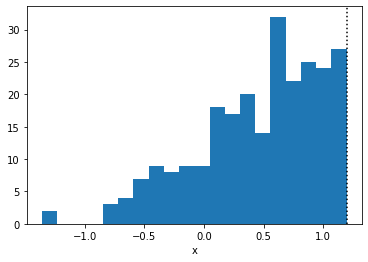

In [5]:
plt.hist(true_x, bins=20)
plt.axvline(high, linestyle=":", color="k")
plt.xlabel("x")
plt.show()

In [6]:
# --- Run MCMC and check estimates and diagnostics
mcmc = MCMC(NUTS(truncated_normal_model), **MCMC_KWARGS)
mcmc.run(RNG, num_observations, high, true_x)
mcmc.print_summary()

# --- Compare to ground truth
print(f"True loc  : {true_loc:3.2}")
print(f"True scale: {true_scale:3.2}")

sample: 100%|█| 4000/4000 [00:01<00:00, 3064.92it/s, 11 steps of size 3.12
sample: 100%|█| 4000/4000 [00:00<00:00, 20961.28it/s, 9 steps of size 3.02
sample: 100%|█| 4000/4000 [00:00<00:00, 20526.51it/s, 3 steps of size 3.39
sample: 100%|█| 4000/4000 [00:00<00:00, 20331.61it/s, 11 steps of size 2.9



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       loc      0.98      0.18      0.95      0.70      1.25   1250.09      1.00
     scale      0.81      0.09      0.80      0.67      0.94   1302.44      1.00

Number of divergences: 0
True loc  : 1.1
True scale: 0.84


#### Removing the truncation

Once we have inferred the parameters of our model, a common task is to understand what the data would look like _without_ the truncation. In this example, this is easily done by simply "pushing" the value of `high` to infinity.

In [7]:
pred = Predictive(truncated_normal_model, posterior_samples=mcmc.get_samples())
pred_samples = pred(
    RNG, num_observations, high=float("inf")
)  # Push the value of high to infinity.

Let's finally plot these samples and compare them to the original, observed data.

In [8]:
# thin the samples to not saturate matplotlib
pred_samples_thinned = pred_samples["x"].ravel()[::1000]

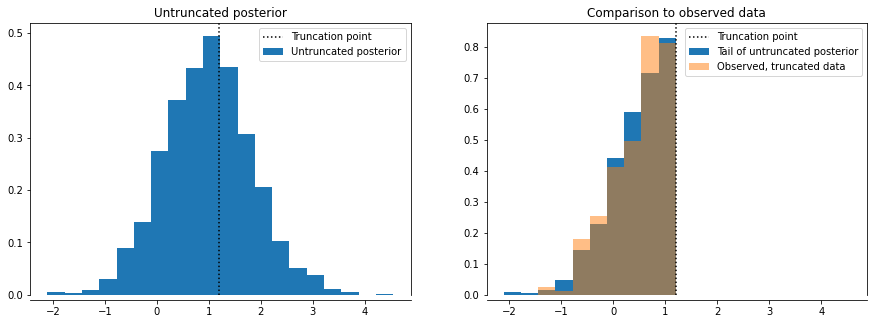

In [9]:
f, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

axes[0].hist(pred_samples_thinned, label="Untruncated posterior", bins=20, density=True)
axes[0].set_title("Untruncated posterior")

vals, bins, _ = axes[1].hist(
    pred_samples_thinned[pred_samples_thinned < high],
    label="Tail of untruncated posterior",
    bins=10,
    density=True,
)
axes[1].hist(
    true_x, bins=bins, label="Observed, truncated data", density=True, alpha=0.5
)
axes[1].set_title("Comparison to observed data")

for ax in axes:
    ax.axvline(high, linestyle=":", color="k", label="Truncation point")
    ax.legend()
    ax.spines.bottom.set_position(("outward", 5))

plt.show()

The plot on the left shows data simulated from the posterior distribution with the truncation removed, so we are able to see how the data would look like if it were not truncated. To sense check this, we discard the simulated samples that are above the truncation point and make histogram of those and compare it to a histogram of the true data (right plot).

### 4.1 `TruncatedDistribution`

The source code for the [`TruncatedNormal`](https://github.com/pyro-ppl/numpyro/blob/6a0856b7cda82fc255e23adc797bb79f5b7fc904/numpyro/distributions/truncated.py#L374) in NumPyro uses a class called
[`TruncatedDistribution`](https://github.com/pyro-ppl/numpyro/blob/6a0856b7cda82fc255e23adc797bb79f5b7fc904/numpyro/distributions/truncated.py#L339) which abstracts away the logic for `sample` and `log_prob` that
we will discuss in the next sections. At the moment, though, this logic only works continuous, symmetric distributions with _real_ support.

We can use this class to quickly construct other truncated distributions. For example, if we need a truncated [`SoftLaplace`](https://github.com/pyro-ppl/numpyro/blob/6a0856b7cda82fc255e23adc797bb79f5b7fc904/numpyro/distributions/continuous.py#L1429) we can use the following pattern:

In [10]:
def TruncatedSoftLaplace(
    loc=0.0, scale=1.0, *, low=None, high=None, validate_args=None
):
    return TruncatedDistribution(
        base_dist=SoftLaplace(loc, scale),
        low=low,
        high=high,
        validate_args=validate_args,
    )

In [11]:
def truncated_soft_laplace_model(num_observations, high, x=None):
    loc = numpyro.sample("loc", dist.Normal())
    scale = numpyro.sample("scale", dist.LogNormal())
    with numpyro.plate("obs", num_observations):
        numpyro.sample("x", TruncatedSoftLaplace(loc, scale, high=high), obs=x)

And, as before, we check that we can use this model in the steps of a typical workflow:

In [12]:
high = 2.3
num_observations = 200
num_prior_samples = 100

prior = Predictive(truncated_soft_laplace_model, num_samples=num_prior_samples)
prior_samples = prior(RNG, num_observations, high)

true_idx = 0
true_x = prior_samples["x"][true_idx]
true_loc = prior_samples["loc"][true_idx]
true_scale = prior_samples["scale"][true_idx]

mcmc = MCMC(
    NUTS(truncated_soft_laplace_model),
    **MCMC_KWARGS,
)

mcmc.run(
    RNG,
    num_observations,
    high,
    true_x,
)

mcmc.print_summary()

print(f"True loc  : {true_loc:3.2}")
print(f"True scale: {true_scale:3.2}")

sample: 100%|█| 4000/4000 [00:01<00:00, 2608.00it/s, 7 steps of size 7.66e
sample: 100%|█| 4000/4000 [00:00<00:00, 16835.52it/s, 3 steps of size 8.21
sample: 100%|█| 4000/4000 [00:00<00:00, 16470.74it/s, 7 steps of size 7.06
sample: 100%|█| 4000/4000 [00:00<00:00, 15831.04it/s, 3 steps of size 6.31


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       loc      0.94      0.10      0.94      0.78      1.10   3531.19      1.00
     scale      0.83      0.07      0.82      0.72      0.94   3982.81      1.00

Number of divergences: 0
True loc  : 1.1
True scale: 0.84


**Important**

The `sample` method of the [`TruncatedDistribution`](https://github.com/pyro-ppl/numpyro/blob/6a0856b7cda82fc255e23adc797bb79f5b7fc904/numpyro/distributions/truncated.py#L339) class relies on inverse-transform sampling.
This has the implicit requirement that the base distribution should have an `icdf` method already available.
If this is not the case, we will not be able to call the `sample` method on any instances of our distribution, nor use it with the `Predicitve` class.
However, the `log_prob` method would work regardless and this means that we are still able to use our distribution as prior/likelihood in a model.

### 4.2 `FoldedDistribution`

Similar to truncated distributions, NumPyro has the [`FoldedDistribution`](https://github.com/pyro-ppl/numpyro/blob/6a0856b7cda82fc255e23adc797bb79f5b7fc904/numpyro/distributions/distribution.py#L1056) class to help you quickly construct folded distributions. Popular examples of folded distributions are the so-called "half-normal", "half-student" or "half-cauchy". As the name suggests, these distributions keep only (the positive) _half_ of the distribution. Implicit in the name of these "half" distributions is that they are centered at zero before folding. But, of course, you can fold a distribution even if its not centered at zero. For instance, this is how you would define a folded student-t distribution.

In [13]:
def FoldedStudentT(df, loc=0.0, scale=1.0):
    return FoldedDistribution(StudentT(df, loc=loc, scale=scale))

In [14]:
def folded_student_model(num_observations, x=None):
    df = numpyro.sample("df", dist.Gamma(6, 2))
    loc = numpyro.sample("loc", dist.Normal())
    scale = numpyro.sample("scale", dist.LogNormal())
    with numpyro.plate("obs", num_observations):
        numpyro.sample("x", FoldedStudentT(df, loc, scale), obs=x)

And we check that we can use our distribution in a typical workflow:

In [15]:
# --- prior sampling
num_observations = 500
num_prior_samples = 100
prior = Predictive(folded_student_model, num_samples=num_prior_samples)
prior_samples = prior(RNG, num_observations)


# --- choose any prior sample as the ground truth
true_idx = 0
true_df = prior_samples["df"][true_idx]
true_loc = prior_samples["loc"][true_idx]
true_scale = prior_samples["scale"][true_idx]
true_x = prior_samples["x"][true_idx]

# --- do inference with MCMC
mcmc = MCMC(
    NUTS(folded_student_model),
    **MCMC_KWARGS,
)
mcmc.run(RNG, num_observations, true_x)

# --- Check diagostics
mcmc.print_summary()

# --- Compare to ground truth:
print(f"True df   : {true_df:3.2f}")
print(f"True loc  : {true_loc:3.2f}")
print(f"True scale: {true_scale:3.2f}")

sample: 100%|█| 4000/4000 [00:02<00:00, 1663.37it/s, 39 steps of size 1.78
sample: 100%|█| 4000/4000 [00:00<00:00, 4011.19it/s, 7 steps of size 1.58e
sample: 100%|█| 4000/4000 [00:01<00:00, 3813.72it/s, 15 steps of size 1.58
sample: 100%|█| 4000/4000 [00:01<00:00, 3577.73it/s, 11 steps of size 1.35



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        df      4.72      1.06      4.59      3.07      6.38   1901.19      1.00
       loc     -0.02      0.56     -0.07     -0.74      0.72    424.98      1.00
     scale      0.98      0.11      0.97      0.81      1.16   1691.41      1.00

Number of divergences: 0
True df   : 6.22
True loc  : -0.17
True scale: 1.08



## 5. Building your own truncated distribution <a class="anchor" id="5"></a>

If the [`TruncatedDistribution`](https://github.com/pyro-ppl/numpyro/blob/6a0856b7cda82fc255e23adc797bb79f5b7fc904/numpyro/distributions/truncated.py#L339) and [`FoldedDistribution`](https://github.com/pyro-ppl/numpyro/blob/6a0856b7cda82fc255e23adc797bb79f5b7fc904/numpyro/distributions/distribution.py#L1056) classes are not sufficient to solve your problem,
you might want to look into writing your own truncated distribution from the ground up.
This can be a tedious process, so this section will give you some guidance and examples to help you with it.

## 5.1 Recap of NumPyro distributions <a class="anchor" id="5.1"></a>

A NumPyro distribution should subclass [`Distribution`](https://num.pyro.ai/en/stable/distributions.html#distribution) and implement a few basic ingredients:

**Class attributes:**
The class attributes serve a few different purposes. Here we will mainly care about two:
1. `arg_constraints`: Impose some requirements on the parameters of the distribution. Errors are raised at instantiation time if the parameters passed do not satisfy the constraints.
2. `support`: It is used in some inference algorithms like MCMC and SVI with auto-guides, where we need to perform the algorithm in the unconstrained space. Knowing the support, we can automatically reparametrize things under the hood.

We'll explain other class attributes as we go.

**The `__init__` method:**
This is where we define the parameters of the distribution.
We also use `jax` and `lax` to promote the parameters to shapes that are valid for broadcasting.
The `__init__` method of the parent class is also required because that's where the validation of our parameters is done.

**The `log_prob` method:**
Implementing the `log_prob` method ensures that we can do inference. As the name suggests, this method returns the logarithm of the density evaluated at the argument.


**The `sample` method:**
This method is used for drawing independent samples from our distribution. It is particularly useful for doing prior and posterior predictive checks. Note, in particular, that this method is not needed if you only need to use your distribution as prior in a model - the `log_prob` method will suffice.


The place-holder code for any of our implementations can be written as
```python
class MyDistribution(Distribution):
    # class attributes
    arg_constraints = {}
    support = None
    def __init__(self):
        pass
    
    def log_prob(self, value):
        pass
    
    def sample(self, key, sample_shape=()):
        pass
```

### 5.2 Example: Right-truncated normal <a class="anchor" id="5.2"></a>

We are going to modify a normal distribution so that its new support is
of the form `(-inf, high)`, with `high` a real number. This could be done with the `TruncatedNormal` distribution but, for the sake of illustration, we are not going to rely on it.
We'll call our distribution `RightTruncatedNormal`. Let's write the skeleton code and then proceed to fill in the blanks.

```python
class RightTruncatedNormal(Distribution):
    # <class attributes>
    def __init__(self):
        pass
    
    def log_prob(self, value):
        pass
    
    def sample(self, key, sample_shape=()):
        pass
```
    

**Class attributes:**

Remember that a non-truncated normal distribution is specified in NumPyro by two parameters, `loc` and `scale`,
which correspond to the mean and standard deviation.
Looking at the [source code](https://github.com/pyro-ppl/numpyro/blob/0664c2d2dd1eb5f41ea6a0bcef91e5fa2a417ce5/numpyro/distributions/continuous.py#L1337) for the `Normal` distribution we see the following lines:

```python
arg_constraints = {"loc": constraints.real, "scale": constraints.positive}
support = constraints.real
reparametrized_params = ["loc", "scale"]
```

The `reparametrized_params` attribute is used by variational inference algorithms when constructing gradient estimators. The parameters of many common distributions with continuous support (e.g. the Normal distribution) are reparameterizable, while the parameters of discrete distributions are not. Note that `reparametrized_params` is irrelevant for MCMC algorithms like HMC. See [SVI Part III](https://pyro.ai/examples/svi_part_iii.html#Tricky-Case:-Non-reparameterizable-Random-Variables) for more details.

We must adapt these attributes to our case by including the `"high"` parameter, but there are two issues we need to deal with:
1. `constraints.real` is a bit too restrictive. We'd like `jnp.inf` to be a valid value for `high` (equivalent to no truncation), but at the moment infinity is not a valid real number. We deal with this situation by defining our own constraint. The source code for `constraints.real` is easy to imitate:

```python
class _RightExtendedReal(constraints.Constraint):
    """
    Any number in the interval (-inf, inf].
    """
    def __call__(self, x):
        return (x == x) & (x != float("-inf"))
    
    def feasible_like(self, prototype):
        return jnp.zeros_like(prototype)

right_extended_real = _RightExtendedReal()
```

2. `support` can no longer be a class attribute as it will depend on the value of `high`. So instead we implement it as a dependent property.

Our distribution then looks as follows:
```python
class RightTruncatedNormal(Distribution):
    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "high": right_extended_real,
    }
    reparametrized_params = ["loc", "scale", "high"]
    
    # ...
    
    @constraints.dependent_property
    def support(self):
        return constraints.lower_than(self.high)
```

**The `__init__` method**

Once again we take inspiration from the [source code](https://github.com/pyro-ppl/numpyro/blob/0664c2d2dd1eb5f41ea6a0bcef91e5fa2a417ce5/numpyro/distributions/continuous.py#L1342) for the normal distribution. The key point is the use of `lax` and `jax` to check the shapes of the arguments passed and make sure that such shapes are consistent for broadcasting. We follow the same pattern for our use case -- all we need to do is include the `high` parameter.

In the source implementation of `Normal`, both parameters `loc` and `scale` are given defaults so that one recovers a standard normal distribution if no arguments are specified. In the same spirit, we choose `float("inf")` as a default for `high` which would be equivalent to no truncation.

```python
# ...
    def __init__(self, loc=0.0, scale=1.0, high=float("inf"), validate_args=None):
        batch_shape = lax.broadcast_shapes(
            jnp.shape(loc),
            jnp.shape(scale),
            jnp.shape(high),
        )
        self.loc, self.scale, self.high = promote_shapes(loc, scale, high)
        super().__init__(batch_shape, validate_args=validate_args)
# ...
```

**The `log_prob` method**

For a truncated distribution, the log density is given by

$$
  \log p_Z(z) =
    \begin{cases}
      \log p_Y(z) - \log M & \text{if $z$ is in $T$}\\
      -\infty & \text{if $z$ is outside $T$}\\
    \end{cases}       
$$

where, again, $p_Z$ is the density of the truncated distribution, $p_Y$ is the density before truncation, and $M = \int_T p_Y(y)\mathrm{d}y$. For the specific case of truncating the normal distribution to the interval `(-inf, high)`, the constant $M$ is equal to the cumulative density evaluated at the truncation point. We can easily implement this log-density method because `jax.scipy.stats` already has a `norm` module that we can use.

```python
# ...
    def log_prob(self, value):
        log_m = norm.logcdf(self.high, self.loc, self.scale)
        log_p = norm.logpdf(value, self.loc, self.scale)
        return jnp.where(value < self.high, log_p - log_m, -jnp.inf)
# ...
```

**The `sample` method**

To implement the sample method using inverse-transform sampling, we need to also implement the inverse cumulative distribution function. For this, we can use the `ndtri` function that lives inside `jax.scipy.special`. This function returns the inverse cdf for the standard normal distribution. We can do a bit of algebra to obtain the inverse cdf of the truncated, non-standard normal. First recall that if $X\sim Normal(0, 1)$ and $Y = \mu + \sigma X$, then $Y\sim Normal(\mu, \sigma)$. Then if $Z$ is the truncated $Y$, its cumulative density is given by:

$$
\begin{align}
F_Z(y) &= \int_{-\infty}^{y}p_Z(r)dr\newline
       &= \frac{1}{M}\int_{-\infty}^{y}p_Y(s)ds \quad\text{if $y < high$} \newline
       &= \frac{1}{M}F_Y(y)
\end{align}
$$

And so its inverse is

$$
\begin{align}
F_Z^{-1}(u) = \left(\frac{1}{M}F_Y\right)^{-1}(u)
            = F_Y^{-1}(M u)
            = F_{\mu + \sigma X}^{-1}(Mu)
            = \mu + \sigma F_X^{-1}(Mu)
\end{align}
$$

The translation of the above math into code is

```python
# ...
    def sample(self, key, sample_shape=()):
        shape = sample_shape + self.batch_shape
        minval = jnp.finfo(jnp.result_type(float)).tiny
        u = random.uniform(key, shape, minval=minval)
        return self.icdf(u)


    def icdf(self, u):
        m = norm.cdf(self.high, self.loc, self.scale)
        return self.loc + self.scale * ndtri(m * u)
```

With everything in place, the final implementation is as below.

In [16]:
class _RightExtendedReal(constraints.Constraint):
    """
    Any number in the interval (-inf, inf].
    """

    def __call__(self, x):
        return (x == x) & (x != float("-inf"))

    def feasible_like(self, prototype):
        return jnp.zeros_like(prototype)


right_extended_real = _RightExtendedReal()


class RightTruncatedNormal(Distribution):
    """
    A truncated Normal distribution.
    :param numpy.ndarray loc: location parameter of the untruncated normal
    :param numpy.ndarray scale: scale parameter of the untruncated normal
    :param numpy.ndarray high: point at which the truncation happens
    """

    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "high": right_extended_real,
    }
    reparametrized_params = ["loc", "scale", "high"]

    def __init__(self, loc=0.0, scale=1.0, high=float("inf"), validate_args=True):
        batch_shape = lax.broadcast_shapes(
            jnp.shape(loc),
            jnp.shape(scale),
            jnp.shape(high),
        )
        self.loc, self.scale, self.high = promote_shapes(loc, scale, high)
        super().__init__(batch_shape, validate_args=validate_args)

    def log_prob(self, value):
        log_m = norm.logcdf(self.high, self.loc, self.scale)
        log_p = norm.logpdf(value, self.loc, self.scale)
        return jnp.where(value < self.high, log_p - log_m, -jnp.inf)

    def sample(self, key, sample_shape=()):
        shape = sample_shape + self.batch_shape
        minval = jnp.finfo(jnp.result_type(float)).tiny
        u = random.uniform(key, shape, minval=minval)
        return self.icdf(u)

    def icdf(self, u):
        m = norm.cdf(self.high, self.loc, self.scale)
        return self.loc + self.scale * ndtri(m * u)

    @constraints.dependent_property
    def support(self):
        return constraints.less_than(self.high)

Let's try it out!

In [17]:
def truncated_normal_model(num_observations, x=None):
    loc = numpyro.sample("loc", dist.Normal())
    scale = numpyro.sample("scale", dist.LogNormal())
    high = numpyro.sample("high", dist.Normal())
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x", RightTruncatedNormal(loc, scale, high), obs=x)

#### Prior

In [18]:
num_observations = 250
num_prior_samples = 100
prior = Predictive(truncated_normal_model, num_samples=num_prior_samples)
prior_samples = prior(RNG, num_observations)

#### Inference

As before, we run mcmc against some synthetic data.
We select any random sample from the prior as the ground truth:

In [19]:
true_idx = 0
true_loc = prior_samples["loc"][true_idx]
true_scale = prior_samples["scale"][true_idx]
true_high = prior_samples["high"][true_idx]
true_x = prior_samples["x"][true_idx]

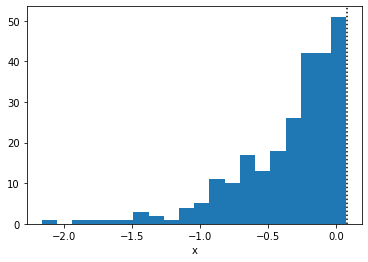

In [20]:
plt.hist(true_x, bins=20)
plt.axvline(true_high, linestyle=":", color="k")
plt.xlabel("x")
plt.show()

Run MCMC and check the estimates:

In [21]:
mcmc = MCMC(NUTS(truncated_normal_model), **MCMC_KWARGS)
mcmc.run(RNG, num_observations, true_x)
mcmc.print_summary()

sample: 100%|█| 4000/4000 [00:01<00:00, 2679.69it/s, 3 steps of size 1.74e
sample: 100%|█| 4000/4000 [00:00<00:00, 18048.50it/s, 11 steps of size 1.2
sample: 100%|█| 4000/4000 [00:00<00:00, 12924.24it/s, 26 steps of size 1.7
sample: 100%|█| 4000/4000 [00:00<00:00, 16729.94it/s, 5 steps of size 1.03


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      high      0.08      0.00      0.08      0.08      0.08    736.20      1.00
       loc      1.35      0.54      1.28      0.45      2.18    128.85      1.03
     scale      0.93      0.13      0.92      0.73      1.15    142.55      1.02

Number of divergences: 6496


Compare estimates against the ground truth:

In [22]:
print(f"True high : {true_high:3.2f}")
print(f"True loc  : {true_loc:3.2f}")
print(f"True scale: {true_scale:3.2f}")

True high : 0.08
True loc  : 1.09
True scale: 0.84


Note that, even though we can recover good estimates for the true values,
we had a very high number of divergences. These divergences happen because
introducing the truncation makes the log-density not smooth (the NUTS
algorithm relies on the differentiability of the posterior). If you need to
infer the truncation point, make sure to be extra careful and do additional
checks on your inferences!

The results are more reliable when the truncation point is already known:

In [23]:
model_with_known_high = numpyro.handlers.condition(
    truncated_normal_model, {"high": true_high}
)

In [24]:
mcmc = MCMC(NUTS(model_with_known_high), **MCMC_KWARGS)
mcmc.run(RNG, num_observations, true_x)
mcmc.print_summary()

sample: 100%|█| 4000/4000 [00:01<00:00, 2796.65it/s, 17 steps of size 2.13
sample: 100%|█| 4000/4000 [00:00<00:00, 19058.30it/s, 11 steps of size 1.7
sample: 100%|█| 4000/4000 [00:00<00:00, 18687.93it/s, 3 steps of size 1.82
sample: 100%|█| 4000/4000 [00:00<00:00, 18797.98it/s, 23 steps of size 1.7


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       loc      1.41      0.56      1.34      0.53      2.25   1285.24      1.00
     scale      0.95      0.13      0.94      0.74      1.15   1308.89      1.00

Number of divergences: 0


And the divergences are gone.

#### Removing the truncation

In practice, we usually want to understand how the data
would look like without the truncation. To do that in NumPyro,
there is no need of writing a separate model, we can simply
rely on the `condition` handler to push the truncation point to infinity:

In [25]:
model_without_truncation = numpyro.handlers.condition(
    model_with_known_high,
    {"high": float("inf")},
)
posterior = Predictive(
    model_without_truncation,
    posterior_samples=mcmc.get_samples(),
)
posterior_samples = posterior(RNG, num_observations=2270)

In [26]:
# thin the samples for a faster histogram
posterior_example = posterior_samples["x"].ravel()[::1000]

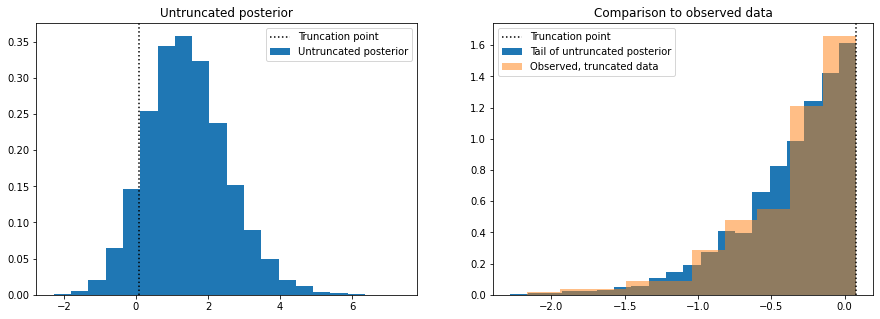

In [27]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(posterior_example, label="Untruncated posterior", bins=20, density=True)
axes[0].axvline(true_high, linestyle=":", color="k", label="Truncation point")
axes[0].set_title("Untruncated posterior")
axes[0].legend()

axes[1].hist(
    posterior_example[posterior_example < true_high],
    label="Tail of untruncated posterior",
    bins=20,
    density=True,
)
axes[1].hist(true_x, label="Observed, truncated data", density=True, alpha=0.5)
axes[1].axvline(true_high, linestyle=":", color="k", label="Truncation point")
axes[1].set_title("Comparison to observed data")
axes[1].legend()
plt.show()

### 5.3 Example: Left-truncated Poisson <a class="anchor" id="5.3"></a>

As a final example, we now implement a left-truncated Poisson distribution.
Note that a right-truncated Poisson could be reformulated as a particular
case of a categorical distribution, so we focus on the less trivial case.

#### Class attributes.
For a truncated Poisson we need two parameters, the `rate` of the original Poisson
distribution and a `low` parameter to indicate the truncation point.
As this is a discrete distribution, we need to clarify whether or not the truncation point is included
in the support. In this tutorial, we'll take the convention that the truncation point `low`
_is_ part of the support.

The `low` parameter has to be given a 'non-negative integer' constraint. As it is a discrete parameter, it will not be possible to do inference for this parameter using [`NUTS`](https://github.com/pyro-ppl/numpyro/blob/6a0856b7cda82fc255e23adc797bb79f5b7fc904/numpyro/infer/hmc.py#L771). This is likely not a problem since the truncation point is often known in advance. However, if we really must infer the `low` parameter, it is possible to do so with [`DiscreteHMCGibbs`](https://github.com/pyro-ppl/numpyro/blob/6a0856b7cda82fc255e23adc797bb79f5b7fc904/numpyro/infer/hmc_gibbs.py#L336) though one is limited to using priors with enumerate support.

Like in the case of the truncated normal, the support of this distribution will be defined as a property and not as a class attribute because it depends on the specific value of the `low` parameter.
```python
class LeftTruncatedPoisson:
    arg_constraints = {
        "low": constraints.nonnegative_integer,
        "rate": constraints.positive,
    }
    
    # ... 
    @constraints.dependent_property(is_discrete=True)
    def support(self):
        return constraints.integer_greater_than(self.low - 1)
```

The `is_discrete` argument passed in the `dependent_property` decorator is used to tell the inference algorithms which variables are discrete latent variables.

#### The `__init__` method
Here we just follow the same pattern as in the previous example.
```python
    # ...
    def __init__(self, rate=1.0, low=0, validate_args=None):
        batch_shape = lax.broadcast_shapes(
            jnp.shape(low), jnp.shape(rate)
        )
        self.low, self.rate = promote_shapes(low, rate)
        super().__init__(batch_shape, validate_args=validate_args)
    # ...
```


#### The `log_prob` method
The logic is very similar to the truncated normal case. But this time we are truncating on the left, so the correct normalization is the complementary cumulative density:

$$
M = \sum_{n=L}^{\infty} p_Y(n) = 1 - \sum_{n=0}^{L - 1} p_Y(n) = 1 - F_Y(L - 1)
$$

For the code, we can rely on the `poisson` module that lives inside `jax.scipy.stats`.

```python
    # ...
    def log_prob(self, value):
        m = 1 - poisson.cdf(self.low - 1, self.rate)
        log_p = poisson.logpmf(value, self.rate)
        return jnp.where(value >= self.low, log_p - jnp.log(m), -jnp.inf)
    # ...
```
#### The `sample` method.
Inverse-transform sampling also works for discrete distributions. The "inverse" cdf of a discrete distribution being defined as:

$$
F^{-1}(u) = \max\left\{n\in \mathbb{N} \rvert F(n) \lt u\right\}
$$

Or, in plain English, $F^{-1}(u)$ is the highest number for which the cumulative density is less than $u$.
However, there's currently no implementation of $F^{-1}$ for the Poisson distribution in Jax (at least, at the moment of writing this tutorial). We have to rely on our own implementation. Fortunately, we can take advantage of the discrete nature of the distribution and easily implement a "brute-force" version that will work for most cases. The brute force approach consists of simply scanning all non-negative integers in order, one by one, until the value of the cumulative density exceeds the argument $u$. The implicit requirement is that we need a way to evaluate the cumulative density for the truncated distribution, but we can calculate that:

$$
\begin{align}
F_Z(z) &= \sum_{n=0}^z p_z(n)\newline
       &= \frac{1}{M}\sum_{n=L}^z p_Y(n)\quad \text{assuming $z >= L$}\newline
       &= \frac{1}{M}\left(\sum_{n=0}^z p_Y(n) - \sum_{n=0}^{L-1}p_Y(n)\right)\newline
       &= \frac{1}{M}\left(F_Y(z) - F_Y (L-1)\right)
\end{align}
$$

And, of course, the value of $F_Z(z)$ is equal to zero if $z < L$.
(As in the previous example, we are using $Y$ to denote the original, un-truncated variable, and we are using $Z$ to denote the truncated variable)

```python
    # ...
    def sample(self, key, sample_shape=()):
        shape = sample_shape + self.batch_shape
        minval = jnp.finfo(jnp.result_type(float)).tiny
        u = random.uniform(key, shape, minval=minval)
        return self.icdf(u)

    def icdf(self, u):
        def cond_fn(val):
            n, cdf = val
            return jnp.any(cdf < u)

        def body_fn(val):
            n, cdf = val
            n_new = jnp.where(cdf < u, n + 1, n)
            return n_new, self.cdf(n_new)
        
        low = self.low * jnp.ones_like(u)
        cdf = self.cdf(low)
        n, _ = lax.while_loop(cond_fn, body_fn, (low, cdf))
        return n.astype(jnp.result_type(int))

    def cdf(self, value):
        m = 1 - poisson.cdf(self.low - 1, self.rate)
        f = poisson.cdf(value, self.rate) - poisson.cdf(self.low - 1, self.rate)
        return jnp.where(k >= self.low, f / m, 0)
```

A few comments with respect to the above implementation:
* Even with double precision, if `rate` is much less than `low`, the above code will not work. Due to numerical limitations, one obtains that `poisson.cdf(low - 1, rate)` is equal (or very close) to `1.0`. This makes it impossible to re-weight the distribution accurately because the normalization constant would be `0.0`.
* The brute-force `icdf` is of course very slow, particularly when `rate` is high. If you need faster sampling, one option would be to rely on a faster search algorithm. For example:
```python
def icdf_faster(self, u):
    num_bins = 200 # Choose a reasonably large value
    bins = jnp.arange(num_bins)
    cdf = self.cdf(bins)
    indices = jnp.searchsorted(cdf, u)
    return bins[indices]
```
The obvious limitation here is that the number of bins has to be fixed a priori (jax does not allow for dynamically sized arrays). Another option would be to rely on an _approximate_ implementation, as proposed in [this article](https://people.maths.ox.ac.uk/gilesm/codes/poissinv/paper.pdf).
* Yet another alternative for the `icdf` is to rely on `scipy`'s implementation and make use of Jax's `host_callback` module. This feature allows you to use Python functions without having to code them in `Jax`. This means that we can simply make use of `scipy`'s implementation of the Poisson ICDF! From the last equation, we can write the _truncated_ icdf as:
$$
F_Z^{-1}(u) = F_Y^{-1}(Mu + F_Y(L-1))
$$
    And in python:

```python
    def scipy_truncated_poisson_icdf(args): # Note: all arguments are passed inside a tuple
        rate, low, u = args
        rate = np.asarray(rate)
        low = np.asarray(low)
        u = np.asarray(u)
        density = sp_poisson(rate)
        low_cdf = density.cdf(low - 1)
        normalizer = 1.0 - low_cdf
        x = normalizer * u + low_cdf
        return density.ppf(x)
```
In principle, it wouldn't be possible to use the above function in our NumPyro distribution because it is not  coded in Jax. The `jax.experimental.host_callback.call` function solves precisely that problem. The code below shows you how to use it, but keep in mind that this is currently an experimental feature so you should expect changes to the module. See the `host_callback` [docs](https://jax.readthedocs.io/en/latest/jax.experimental.host_callback.html) for more details.

```python
    # ...
    def icdf_scipy(self, u):
        result_shape = jax.ShapeDtypeStruct(
            u.shape,
            jnp.result_type(float) # int type not currently supported
        )
        result = jax.experimental.host_callback.call(
            scipy_truncated_poisson_icdf,
            (self.rate, self.low, u),
            result_shape=result_shape
        )
        return result.astype(jnp.result_type(int))
    # ...
```

Putting it all together, the implementation is as below:

In [28]:
def scipy_truncated_poisson_icdf(args):  # Note: all arguments are passed inside a tuple
    rate, low, u = args
    rate = np.asarray(rate)
    low = np.asarray(low)
    u = np.asarray(u)
    density = sp_poisson(rate)
    low_cdf = density.cdf(low - 1)
    normalizer = 1.0 - low_cdf
    x = normalizer * u + low_cdf
    return density.ppf(x)


class LeftTruncatedPoisson(Distribution):
    """
    A truncated Poisson distribution.
    :param numpy.ndarray low: lower bound at which truncation happens
    :param numpy.ndarray rate: rate of the Poisson distribution.
    """

    arg_constraints = {
        "low": constraints.nonnegative_integer,
        "rate": constraints.positive,
    }

    def __init__(self, rate=1.0, low=0, validate_args=None):
        batch_shape = lax.broadcast_shapes(jnp.shape(low), jnp.shape(rate))
        self.low, self.rate = promote_shapes(low, rate)
        super().__init__(batch_shape, validate_args=validate_args)

    def log_prob(self, value):
        m = 1 - poisson.cdf(self.low - 1, self.rate)
        log_p = poisson.logpmf(value, self.rate)
        return jnp.where(value >= self.low, log_p - jnp.log(m), -jnp.inf)

    def sample(self, key, sample_shape=()):
        shape = sample_shape + self.batch_shape
        float_type = jnp.result_type(float)
        minval = jnp.finfo(float_type).tiny
        u = random.uniform(key, shape, minval=minval)
        # return self.icdf(u)        # Brute force
        # return self.icdf_faster(u) # For faster sampling.
        return self.icdf_scipy(u)  # Using `host_callback`

    def icdf(self, u):
        def cond_fn(val):
            n, cdf = val
            return jnp.any(cdf < u)

        def body_fn(val):
            n, cdf = val
            n_new = jnp.where(cdf < u, n + 1, n)
            return n_new, self.cdf(n_new)

        low = self.low * jnp.ones_like(u)
        cdf = self.cdf(low)
        n, _ = lax.while_loop(cond_fn, body_fn, (low, cdf))
        return n.astype(jnp.result_type(int))

    def icdf_faster(self, u):
        num_bins = 200  # Choose a reasonably large value
        bins = jnp.arange(num_bins)
        cdf = self.cdf(bins)
        indices = jnp.searchsorted(cdf, u)
        return bins[indices]

    def icdf_scipy(self, u):
        result_shape = jax.ShapeDtypeStruct(u.shape, jnp.result_type(float))
        result = jax.experimental.host_callback.call(
            scipy_truncated_poisson_icdf,
            (self.rate, self.low, u),
            result_shape=result_shape,
        )
        return result.astype(jnp.result_type(int))

    def cdf(self, value):
        m = 1 - poisson.cdf(self.low - 1, self.rate)
        f = poisson.cdf(value, self.rate) - poisson.cdf(self.low - 1, self.rate)
        return jnp.where(value >= self.low, f / m, 0)

    @constraints.dependent_property(is_discrete=True)
    def support(self):
        return constraints.integer_greater_than(self.low - 1)

Let's try it out!

In [29]:
def discrete_distplot(samples, ax=None, **kwargs):
    """
    Utility function for plotting the samples as a barplot.
    """
    x, y = jnp.unique(samples, return_counts=True)
    y = y / sum(y)
    if ax is None:
        ax = plt.gca()

    ax.bar(x, y, **kwargs)
    return ax

In [30]:
def truncated_poisson_model(num_observations, x=None):
    low = numpyro.sample("low", dist.Categorical(0.2 * jnp.ones((5,))))
    rate = numpyro.sample("rate", dist.LogNormal(1, 1))
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x", LeftTruncatedPoisson(rate, low), obs=x)

#### Prior samples

In [31]:
# -- prior samples
num_observations = 1000
num_prior_samples = 100
prior = Predictive(truncated_poisson_model, num_samples=num_prior_samples)
prior_samples = prior(RNG, num_observations)

#### Inference

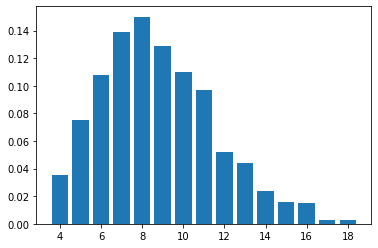

In [32]:
# Take any prior sample as the true process.
true_idx = 4
true_low = prior_samples["low"][true_idx]
true_rate = prior_samples["rate"][true_idx]
true_x = prior_samples["x"][true_idx]
discrete_distplot(true_x);

Note the use of DiscreteHMCGibbs

In [33]:
mcmc = MCMC(DiscreteHMCGibbs(NUTS(truncated_poisson_model)), **MCMC_KWARGS)

In [34]:
mcmc.run(RNG, num_observations, true_x)
mcmc.print_summary()

sample: 100%|█| 4000/4000 [00:02<00:00, 1800.81it/s, 1 steps of size 1.00e
sample: 100%|█| 4000/4000 [00:00<00:00, 10439.42it/s, 3 steps of size 8.36
sample: 100%|█| 4000/4000 [00:00<00:00, 10386.08it/s, 3 steps of size 8.65
sample: 100%|█| 4000/4000 [00:00<00:00, 10536.67it/s, 3 steps of size 1.02



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       low      4.00      0.00      4.00      4.00      4.00       nan       nan
      rate      8.61      0.10      8.61      8.45      8.78   2615.67      1.00



We also see some "ugly" diagnostics here simply because the `low` parameter is estimated with
no uncertainty. As before, one needs to be extra careful when estimating the truncation point.
If the truncation point is known is best to provide it.

In [35]:
model_with_known_low = numpyro.handlers.condition(
    truncated_poisson_model, {"low": true_low}
)

And note we can use NUTS directly because there's no need to infer any discrete parameters.

In [36]:
mcmc = MCMC(
    NUTS(model_with_known_low),
    **MCMC_KWARGS,
)

In [37]:
mcmc.run(RNG, num_observations, true_x)
mcmc.print_summary()

sample: 100%|█| 4000/4000 [00:01<00:00, 2709.85it/s, 1 steps of size 1.18e
sample: 100%|█| 4000/4000 [00:00<00:00, 11919.48it/s, 3 steps of size 1.02
sample: 100%|█| 4000/4000 [00:00<00:00, 11929.55it/s, 3 steps of size 1.13
sample: 100%|█| 4000/4000 [00:00<00:00, 11733.21it/s, 3 steps of size 9.07


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      rate      8.61      0.10      8.61      8.44      8.77   2827.71      1.00

Number of divergences: 0


#### Removing the truncation

In [38]:
model_without_truncation = numpyro.handlers.condition(
    truncated_poisson_model,
    {"low": 0},
)
pred = Predictive(model_without_truncation, posterior_samples=mcmc.get_samples())
pred_samples = pred(RNG, num_observations)
thinned_samples = pred_samples["x"][::500]

<AxesSubplot:>

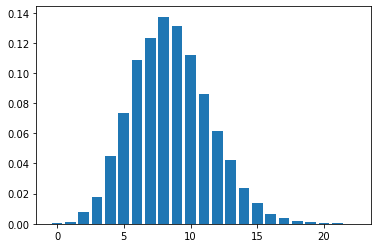

In [39]:
discrete_distplot(thinned_samples)

## 6. References and related material <a class="anchor" id="6"></a>

1. [Wikipedia page on inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling)
2. [David Mackay's book on information theory](http://www.inference.org.uk/itprnn/book.pdf)
3. <a class="anchor" id="ref3"></a>[Composite models with underlying folded distributions](https://www.sciencedirect.com/science/article/pii/S0377042720306427)
4. <a class="anchor" id="ref4"></a>[Application of the generalized folded-normal distribution to the process capability measures](https://link.springer.com/article/10.1007/s00170-003-2043-x)
4. [Pyro SVI tutorial part 3](https://pyro.ai/examples/svi_part_iii.html)
5. [Approximation of the inverse Poisson cumulative distribution function](https://people.maths.ox.ac.uk/gilesm/codes/poissinv/paper.pdf)